In [25]:
### The packages needed for this notebook to run through.

import odl
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from select_image import select_image
from select_geometry import geometry_and_ray_trafo
from select_algorithm import algorithm

In [26]:
### Here one loads the image which is used in these classical algorithms. 

### Define your own path to the image.
path = '/home/asalline/Documents/summer2023/algorithms/usable_full_AGD_50_000230.tiff'

### Load the image.
image = cv.imread(path, cv.IMREAD_UNCHANGED)
image = image[90:410, 90:410]
# image = image[0:320:factor, 0:320:factor]

### Normalizing the image and taking its shape.
image = image / np.max(np.max(image))
shape = np.shape(image)

### Fan beam geometry:

In the next code section one defines a fan beam geometry which simulates the geometry of the CT-scan. <br>
After when the geometry is defined, one defines a domain for ray transform and ray transform itself.

In [27]:
### There is couple of parameters:

### What kind measurement environment one wants to choose.
### Possible options are 'full', 'sparse', 'limited'.
setup = 'full'

### Factor down amount of the detection lines, must be int.
factor_lines = 1

### Radius from the source to object.
source_radius = 2

### Radius from te object to detector.
detector_radius = 1

if setup == 'full':
    angles = odl.uniform_partition(0, 2*np.pi, 360)
    lines = odl.uniform_partition(-np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'sparse':
    angle_measurements = 100
    line_measurements = int(1024/factor_lines)
    angles = odl.uniform_partition(0, 2*np.pi, angle_measurements)
    lines = odl.uniform_partition(-1*np.pi, np.pi, line_measurements)
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'limited':
    starting_angle = 0
    final_angle = np.pi * 3/4
    angles = odl.uniform_partition(starting_angle, final_angle, 360)
    lines = odl.uniform_partition(-1*np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)


### The domain is defined here, there is couple of parameters:

### Imagine a box in 2D-plane with this parameter being the most southwest point of the box.
min_domain_corner = [-1,-1]

### Imagine a box in 2D-plane with this parameter being the most northeast point of the box.
max_domain_corner = [1,1]

### Number of samples per axis.
shape = shape

### Data type 
dtype = 'float32'

domain = odl.uniform_discr(min_domain_corner, max_domain_corner, shape=shape, dtype=dtype)

### The ray transform is defined here

device = 'astra_cpu'

ray_transform = odl.tomo.RayTransform(domain, geometry, impl=device)

### Sinogram and noise

Next up is using the ray transform to obtain a sinogram from the image. <br>
After that one can/will add there noise, in this notebook Gaussian noise is used.

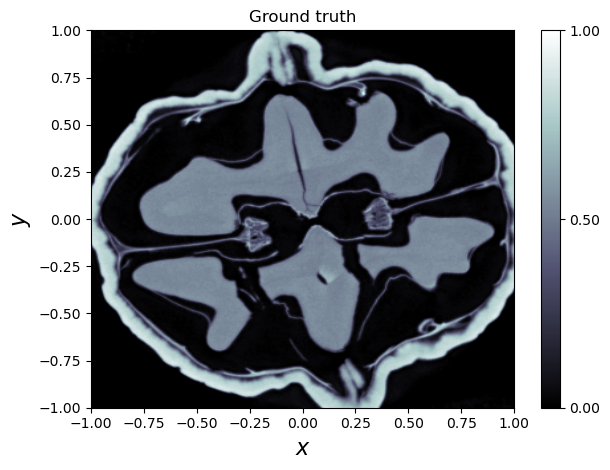

<Figure size 640x480 with 0 Axes>

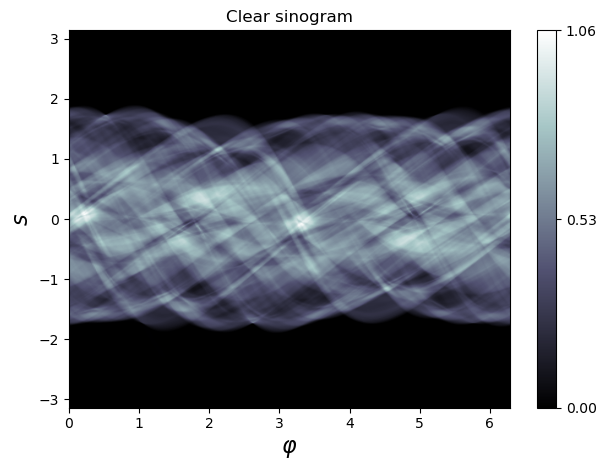

<Figure size 640x480 with 0 Axes>

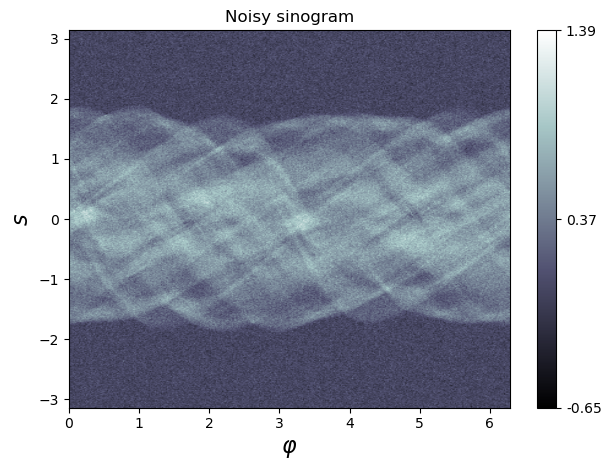

<Figure size 640x480 with 0 Axes>

In [28]:
### First convers image into ODL form
image = domain.element(image)

### Use ray transform to the image to obtain sinogram
sinogram = ray_transform(image)

### Parameters for the Gaussian noise
mean = 0.0
variance = 0.002
sigma = variance ** 0.5

### Create noisy sinogram
noisy_sinogram = sinogram + np.random.normal(mean, sigma, size=(np.shape(sinogram)[0], np.shape(sinogram)[1]))

image.show('Ground truth')
sinogram.show('Clear sinogram')
noisy_sinogram.show('Noisy sinogram')
plt.show()

### Reconstruction methods

Last sections contain different kind of reconstruction algorithms. <br>

### Filtered Back Projection (FBP):

This is the approximate inverse of ray transform. <br>
This is easy to define in the ODL as one can see below.

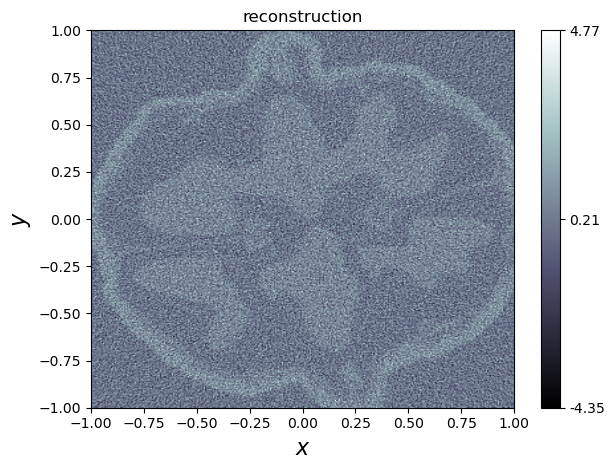

<Figure size 640x480 with 0 Axes>

In [29]:
### There is function in ODL to create FBP operator:
FBP_operator = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo=ray_transform, padding=1)

### One just applies the noisy sinogram with just defined FBP operator and gets a reconstruction out.
reconstruction = FBP_operator(noisy_sinogram)

### Because in these sections the images are plotted in ODL domain the next thing is needed:
reconstruction = domain.element(reconstruction)

### Plotting the reconstructed image
reconstruction.show('reconstruction')
plt.show()